In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
embeddings = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/MoNA_embeddings_multiple_instrument_types.csv')
spectra = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

In [3]:
def plot_emb_pca(all_embeddings, output_embeddings, output_labels, all_chemical_names):
    """
    Run pca on embeddings from denoiser output. Plot results against pca of Chemception embeddings.

    Args:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - output_embeddings (list): Encoder output embeddings.
    - output_labels (list): Chemical names for each embedding in the encoder's output.
    - all_chemical_names (list): Sorted list of all chemical names in the training data.
    """
    
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    true_embeddings = [all_embeddings[chem] for chem in all_chemical_names]    
    true_transformed = pca.transform(true_embeddings)

    output_transformed = pca.transform(output_embeddings)

    color_map = {chem: idx for idx, chem in enumerate(all_chemical_names)}

    # Map labels to colors for both true and output embeddings
    true_colors = [color_map[chem] for chem in all_chemical_names]
    output_colors = [color_map[chem] for chem in output_labels]

    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')

    unique_labels = sorted(list(set(output_labels)))
    output_x = [pair[0] for pair in output_transformed]
    output_y = [pair[1] for pair in output_transformed]
    plt.scatter(output_x, output_y, marker='x', c=output_colors, cmap='tab20')

    plt.legend(handles=scatter.legend_elements()[0],
                labels=unique_labels,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings vs. Denoiser Output')
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [4]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))

  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)
def plot_results(real_spectra, fake_spectra, labels, idx=[0,10], window=300, cutoff = 0.5):

  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plotting spectra within the specified idx range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:

      numbers = range(0,window)
      input_frequencies = real_spec.copy()
      input_max = max(input_frequencies)
      scaled_input = [num/input_max * 100 for num in input_frequencies]

      out_clone = fake_spec.copy()
      output_max = max(out_clone)
      scaled_out = [num/output_max * 100 for num in out_clone]
      out_frequencies = [0 if num < cutoff else num for num in scaled_out]

      weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, input_frequencies)

      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, scaled_input[:window])
      ax[0].set_title(f'Real {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity is: ', round(float(weighted_cosine_similarity), 2))
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

In [5]:
def create_dataset_sections(spectra, embeddings, columns, batch_size=32, noise_loc = None, noise_pct = None, test=False):
  
    """
    Given a list of column names, return a DataLoader object with data for those columns

    Args:
    - spectra (pd.DataFrame): Mass spec data with observations as columns.
    - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - columns (list): Column names to be included in the dataset 
    - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
    - noise_pct (float): percent of noise to introduce to target location
    
    Returns:
    - input_data (DataLoader object): spectrum, encoding information and embedding, labels - chem names
    """
    input_list = []
    true_list = []

    # create lists of spectrum data, condition encoding and chemception embedding with noise as specified in the noise_loc argument
    labels = []

    spectrum_data = spectra[list(columns)][:915].values.copy()
    true_list.append(spectrum_data)
    input_spectra = spectrum_data.copy()
    # generate a list of random indices of len = noise_pct% of target location and change values at each index to 0
    if noise_loc == 'spectra':
        for spec in input_spectra:
            noise = noise_pct * len(spec)
            random_numbers = random.sample(range(len(spec)), int(round(noise)))
            for i in random_numbers:
                spec[i] = 0
    input_list.append(input_spectra)

    # condition_encodings = spectra[list(columns)][-12:].values.copy()
    condition_encodings = spectra[list(columns)][965:977].values.copy()
    true_list.append(condition_encodings)
    input_condition = condition_encodings.copy()
    if noise_loc == 'conditions':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = 0
    input_list.append(input_condition)

    true_embeddings = []
    input_embeddings = []
    for col in columns:
        input_embedding = embeddings[col.split('.')[0]].copy()
        true_embeddings.append(embeddings[col.split('.')[0]].copy())
        if noise_loc == 'embeddings':
            noise = noise_pct * len(input_embedding)
            random_numbers = random.sample(range(len(input_embedding)), int(round(noise)))
            for i in random_numbers:
                input_embedding[i] = 0
        if test:
            noise = noise_pct * len(input_embedding)
            random_numbers = random.sample(range(len(input_embedding)), int(round(noise)))
            for i in random_numbers:
                input_embedding[i] = 0
        input_embeddings.append(input_embedding)
        # label is chemical name encoding
        # labels.append(list(spectra[col][915:-12]))
        labels.append(list(spectra[col][915:965]))
    
    c_ring_encodings = spectra[list(columns)][977:982].values.copy()
    true_list.append(c_ring_encodings)
    input_condition = c_ring_encodings.copy()
    if noise_loc == 'carbon rings':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = 0
    input_list.append(input_condition)

    branch_encodings = spectra[list(columns)][982:].values.copy()
    true_list.append(branch_encodings)
    input_condition = branch_encodings.copy()
    if noise_loc == 'carbon rings':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = 0
    input_list.append(input_condition)
    
    true_list.append(torch.tensor(true_embeddings).T)
    input_list.append(torch.tensor(input_embeddings).T)

    labels = torch.tensor(labels, dtype=torch.float)

    # shifting to make all data positive
    min_value = 1
    input_data = torch.tensor(np.vstack((input_list)).T, dtype=torch.float)
    input_data += min_value
    all_true_vals = torch.tensor(np.vstack((true_list)).T, dtype=torch.float)
    all_true_vals += min_value
    # log transforming data to reduce impact of different scales 
    input_normed = torch.log(input_data)
    trues_normed = torch.log(all_true_vals)
    input_data = TensorDataset(input_normed, trues_normed, labels)

    # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
    input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)

    return input_data

In [6]:
def create_dataset(spectra, embeddings, test_chems = ['Succinic Acid'], instrument_idx = 8, batch_size=32, training_chems = None, noise_loc = None, noise_pct = None):
  """
  Args:
  - spectra (pd.DataFrame): Mass spec data with observations as columns.
  - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
  - test_chems (list): List of chemicals to be used as test data
  - instrument_idx (int): Encoded index of instrument to be set aside for testing
  - batch_size (int): Batch size to use for training
  - training_chems (list): When training small group models this param can be used to specify which chems to include in the dataset
  - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
  - noise_pct (float): percent of noise to introduce to target location

  Returns:
    Tuple:
    - train_input (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - test_input (DataLoader object): spectrum, encoding information and embedding, with noise in specified location, labels - chem names
  """

  if noise_loc not in ['spectra', 'embeddings', 'conditions', None]:
    raise ValueError("Invalid value for 'noise_loc'. Please choose from 'spectra', 'embeddings', 'conditions', or None.")
  
  all_test_chem_columns = [col for col in spectra.columns if col.split('.')[0] in test_chems]

  # separate specified chemical and instrument type for testing  
  test_cols = []
  
  if instrument_idx:
    for col in all_test_chem_columns:
      # instrument_encoding = list(spectra[col][-12:])
      instrument_encoding = list(spectra[col][965:977])
      # filter out the test instrument type
      if instrument_encoding.index(1) == instrument_idx:
        test_cols.append(col)
  else:
    test_cols = all_test_chem_columns

  # use either specified chemicals (for small group training) or everything except test cols for training data
  non_test_cols = set(spectra.columns) - set(test_cols)
  if training_chems:
    train_cols = [col for col in non_test_cols if col.split('.')[0] in training_chems]
  else:
    train_cols = non_test_cols

  train_input = create_dataset_sections(spectra, embeddings, train_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct)
  test_input = create_dataset_sections(spectra, embeddings, test_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct, test=True)

  return train_input, test_input

In [7]:
class Denoiser(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.denoiser = nn.Sequential(
      nn.Linear(1445,1445),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1445,1445),
    )

    self.optimizer = torch.optim.AdamW(self.parameters(), lr = .0001)
    self.criterion = nn.MSELoss()

  def forward(self, x):
    x = self.denoiser(x)
    return x

In [8]:
def get_loss(model, true_vals, output_0, output_1, output_2, start_idx, end_idx):
    true_data = true_vals[:,start_idx:end_idx]
    output_data_0 = output_0[:, start_idx:end_idx]
    output_data_1 = output_1[:, start_idx:end_idx]
    output_data_2 = output_2[:, start_idx:end_idx]

    m_0_loss = model.criterion(output_data_0, true_data)
    m_1_loss = model.criterion(output_data_1, true_data)
    m_2_loss = model.criterion(output_data_2, true_data)
    loss = m_0_loss + m_1_loss + m_2_loss 
    return loss

In [9]:
def train_denoiser(model, data, test_data, sorted_chemical_names, epochs, train_loss_log = [], test_loss_log = []):
    """
    Args:
    - model (Denoiser): Instantiated Denoiser model.
    - data (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - sorted_chemical_names (list): Sorted list of all chemical names in the training data.
    - epochs (int): Number of epochs to train for.

    Returns:
    - model_output (list): Training data with noisy areas filled in.
    - output_labels (list): Chemical name labels for training data. 
    - true_vals_output (list): Original training data without noise
    """

    model_output = []
    output_labels = []
    true_vals_output = []
    for epoch in range(epochs):
        with torch.no_grad(): 
            test_loss = 0
            for batch, true_vals, labels in test_data:
                output_0= model(batch)
                output_1= model(output_0)
                output_2= model(output_1)
                m_0_loss = model.criterion(output_0, true_vals)
                m_1_loss = model.criterion(output_1, true_vals)
                m_2_loss = model.criterion(output_2, true_vals)

                loss = m_0_loss + m_1_loss + m_2_loss
                test_loss += loss 

            average_test_loss = test_loss/len(test_data)
            
        # accumulate epoch output and loss
        epoch_training_loss = 0
        epoch_spec_loss = 0
        epoch_cond_loss = 0
        epoch_emb_loss = 0
        for batch, true_vals, labels in data:
            output_0= model(batch)
            output_1= model(output_0)
            output_2= model(output_1)
            
            spec_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=0, end_idx=915)
            epoch_spec_loss+=spec_loss
            cond_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=915, end_idx=927)
            epoch_cond_loss+=cond_loss
            emb_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=927, end_idx=1439)
            epoch_emb_loss+=emb_loss

            m_0_loss = model.criterion(output_0, true_vals)
            m_1_loss = model.criterion(output_1, true_vals)
            m_2_loss = model.criterion(output_2, true_vals)
            
            loss = m_0_loss + m_1_loss + m_2_loss
            epoch_training_loss += loss

            # back propogation
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()

            if (epoch+1)==epochs:
                chem_names = [sorted_chemical_names[list(encoding).index(1)] for encoding in labels]
                for denoised_vector, chem_name, true_val in zip(output_2, chem_names, true_vals):
                    # undo log transformation
                    denoised_vector = torch.exp(denoised_vector) - 1
                    model_output.append(denoised_vector)
                    true_val = torch.exp(true_val) - 1 
                    true_vals_output.append(true_val)
                    output_labels.append(chem_name)
        

        average_loss = epoch_training_loss/len(data)
        avg_spec_loss = epoch_spec_loss/len(data)
        avg_cond_loss = epoch_cond_loss/len(data)
        avg_emb_loss = epoch_emb_loss/len(data)

        train_loss_log.append(average_loss.detach().numpy())
        test_loss_log.append(average_test_loss.detach().numpy())
        
        if (epoch+1) % 10 == 0:
            print('Epoch[{}/{}], train loss: {}, test loss: {}'.format(epoch+1, epochs, round(float(average_loss.detach().numpy()), 6), round(float(average_test_loss.detach().numpy()), 6)))
            print(f'Spec: {round(float(avg_spec_loss.detach().numpy()), 6)}, Cond: {round(float(avg_cond_loss.detach().numpy()), 6)}, Emb: {round(float(avg_emb_loss.detach().numpy()), 6)}')
            print('--------------------------------------------------------')

    return model_output, output_labels, true_vals_output, train_loss_log, test_loss_log

In [10]:
# create sorted list of all chemical names in the dataset
all_chemical_names = []
for col in spectra:
    chem = col.split('.')[0]
    if chem not in all_chemical_names:
        all_chemical_names.append(chem)

all_chemical_names = sorted(all_chemical_names)

In [11]:
one_carbon_ring = ['Allantoin', '4-Hydroxyphenylpyruvic Acid','L-Tyrosine', 'Benzoic Acid', 'Hexachlorobenzene', 'Methyl Benzoate', 'Benzyl Alcohol']
two_carbon_rings = ['Caffeine', 'Biphenyl', 'Naphthalene', 'Benzyl Benzoate']
three_carbon_rings = ['Phenanthrene', 'Anthracene', 'Fluorene']
four_carbon_rings = ['Pyrene', 'Testosterone']
branches = ['Succinic Acid', 'Gamma-Amino-N-Butyric Acid', 'Malonic Acid', 'L-Aspartic Acid', 'L-Asparagine', 'Glycylglycine', 'Glutaric Acid', 'Fumaric Acid', 
            'L-Serine', 'Allantoin', '4-Hydroxyphenylpyruvic Acid', 'Beta-Alanine', 'L-Valine', 'L-Ornithine', 'L-Norleucine', 'L-Lysine', 'L-Glutamine', 
            'L-Alanine', 'L-Tyrosine', 'Tryptophan', 'L-Leucine', 'Glycine', 'Glycerol', 'Caffeine', 'Phenanthrene', 'Lauric Acid', 'Benzoic Acid', 'Anthracene', 
            '(5R,11R)-5,11-Dimethylpentacosane', 'Pyrene', 'Fluorene', 'Biphenyl', 'Hexachlorobenzene', 'Benzyl Benzoate', 'Methyl Benzoate', 'Methyl Octadecanoate', 
            'Isopentyl Acetate', 'Methyl Hexanoate', '2-Octanol', 'Benzyl Alcohol', 'Testosterone']
spectra_new_conditions = {}
for spec in spectra:
    chem = spec.split('.')[0]
    if chem in one_carbon_ring:
        c_rings = pd.Series([0,1,0,0,0])
    elif chem in two_carbon_rings:
        c_rings = pd.Series([0,0,1,0,0])
    elif chem in three_carbon_rings:
        c_rings = pd.Series([0,0,0,1,0])
    elif chem in four_carbon_rings:
        c_rings = pd.Series([0,0,0,0,1])
    else:
        c_rings = pd.Series([0,0,0,0,0])
    
    if chem in branches:
        branch = pd.Series([1])
    else:
        branch = pd.Series([0])
    
    conds = pd.concat([c_rings, branch])
    data = pd.concat([spectra[spec], conds], ignore_index=True)
    spectra_new_conditions[spec] = data

spectra_new_conditions = pd.DataFrame(spectra_new_conditions)

/home/cmdunham/mass_spec/mass_spec_env/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch[10/100], train loss: 0.208614, test loss: 0.392827
Spec: 0.290954, Cond: 0.073098, Emb: 0.066256
--------------------------------------------------------
Epoch[20/100], train loss: 0.173983, test loss: 0.389346
Spec: 0.254454, Cond: 0.066507, Emb: 0.034234
--------------------------------------------------------
Epoch[30/100], train loss: 0.153611, test loss: 0.386918
Spec: 0.23029, Cond: 0.058524, Emb: 0.020299
--------------------------------------------------------
Epoch[40/100], train loss: 0.144587, test loss: 0.385357
Spec: 0.218782, Cond: 0.05409, Emb: 0.015558
--------------------------------------------------------
Epoch[50/100], train loss: 0.135439, test loss: 0.38349
Spec: 0.206427, Cond: 0.048866, Emb: 0.012009
--------------------------------------------------------
Epoch[60/100], train loss: 0.128168, test loss: 0.382388
Spec: 0.195894, Cond: 0.043454, Emb: 0.010449
--------------------------------------------------------
Epoch[70/100], train loss: 0.123875, test l

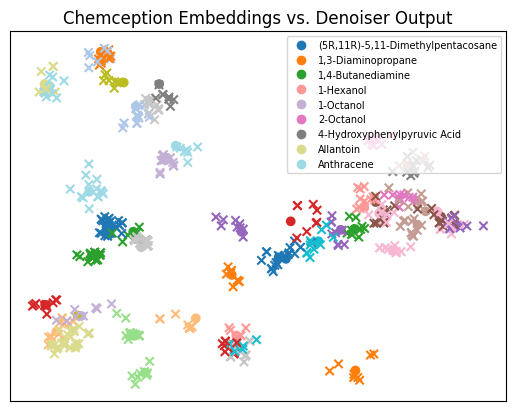

In [12]:
loss_type = 'spectra'
train_noisy_data, test_noisy_data = create_dataset(spectra_new_conditions, embeddings, noise_loc=loss_type, noise_pct=1, test_chems=['Naphthalene'], instrument_idx=None)
# noise_loc = 'spectra'
# train_noisy_data, test_noisy_data = create_dataset(spectra, embeddings, noise_loc=noise_loc, noise_pct=1)
denoiser = Denoiser()
model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=100, train_loss_log = [], test_loss_log = [])
output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)

In [13]:
# true_spectra = [vec[:915].detach().numpy() for vec in true_values]
# output_spectra = [vec[:915].detach().numpy() for vec in model_output]
# plot_results(true_spectra, output_spectra, output_labels, idx=[1,2])
# noise_loc = 'spectra'
# train_noisy_data, test_noisy_data = create_dataset(spectra, embeddings, noise_loc=noise_loc, noise_pct=1)
# denoiser = Denoiser()
# model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=200, train_loss_log = [], test_loss_log = [])
# # create x-axis values
# epochs = range(1, len(train_loss_log) + 1)

# # plot train and test loss
# plt.plot(epochs, train_loss_log, 'b', label='Training loss')
# plt.plot(epochs, test_loss_log, 'r', label='Testing loss')
# plt.legend()
# plt.show()
# denoiser.optimizer = torch.optim.AdamW(denoiser.parameters(), lr=.00001)
# model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=100, train_loss_log=train_loss_log, test_loss_log=test_loss_log)
# output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
# plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)
# denoiser_path = '/home/cmdunham/mass_spec/mass_spec_repo/models/denoiser_tmp.pth'
# torch.save(denoiser.state_dict(), denoiser_path)

In [14]:
denoiser.eval()
test_output = []
test_labels = []
test_true_values = []
test_loss = 0

with torch.no_grad(): 
    for batch, true_vals, labels in test_noisy_data:
        output_0= denoiser(batch)
        output_1= denoiser(output_0)
        output_2= denoiser(output_1)

        m_0_loss = denoiser.criterion(output_0, true_vals)
        m_1_loss = denoiser.criterion(output_1, true_vals)
        m_2_loss = denoiser.criterion(output_2, true_vals)

        loss = m_0_loss + m_1_loss + m_2_loss
        test_loss+=loss

        chem_names = [all_chemical_names[list(encoding).index(1)] for encoding in labels]
        for denoised_vector, chem_name, true_val in zip(output_2, chem_names, true_vals):
            # undo log transformation
            denoised_vector = torch.exp(denoised_vector) - 1
            test_output.append(denoised_vector)
            true_val = torch.exp(true_val) - 1 
            test_true_values.append(true_val)
            test_labels.append(chem_name)

    average_loss = test_loss/len(test_noisy_data)
    print('Loss =', average_loss)

Loss = tensor(0.3784)


Weighted cosine similarity is:  0.16


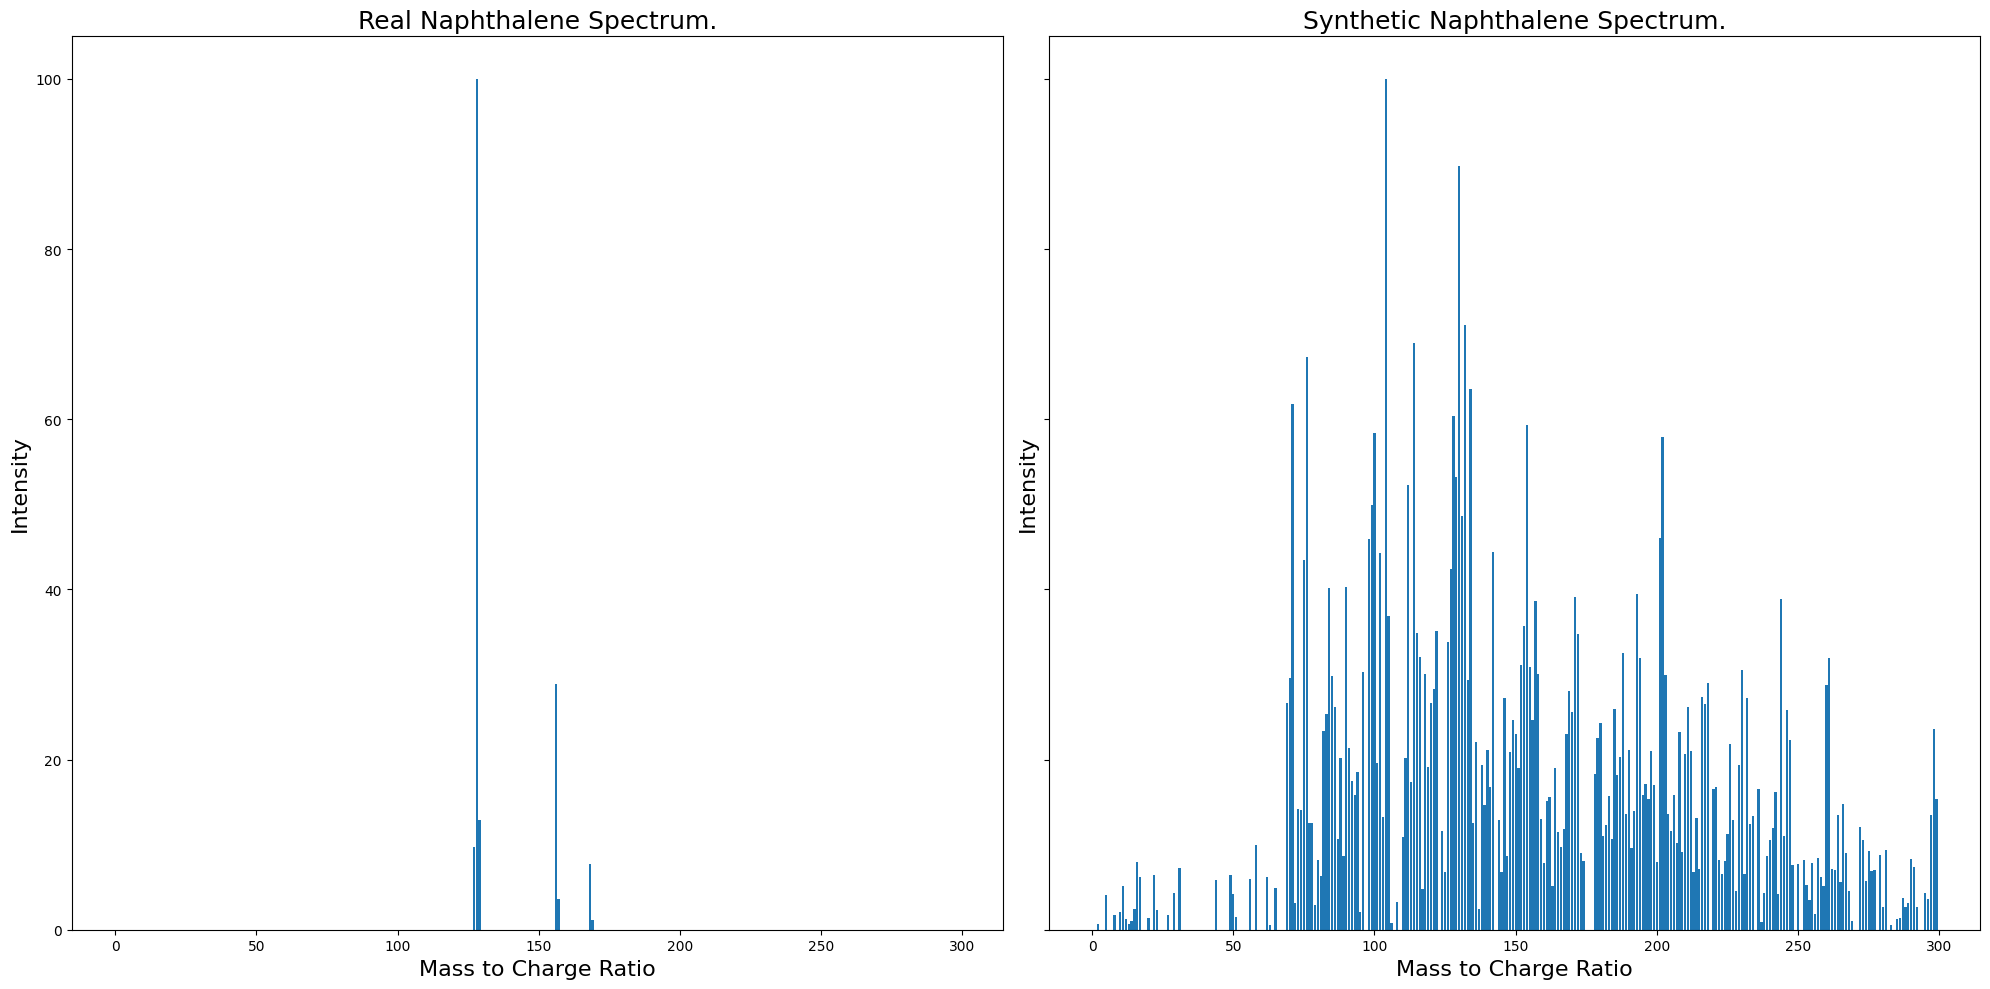

Weighted cosine similarity is:  0.14


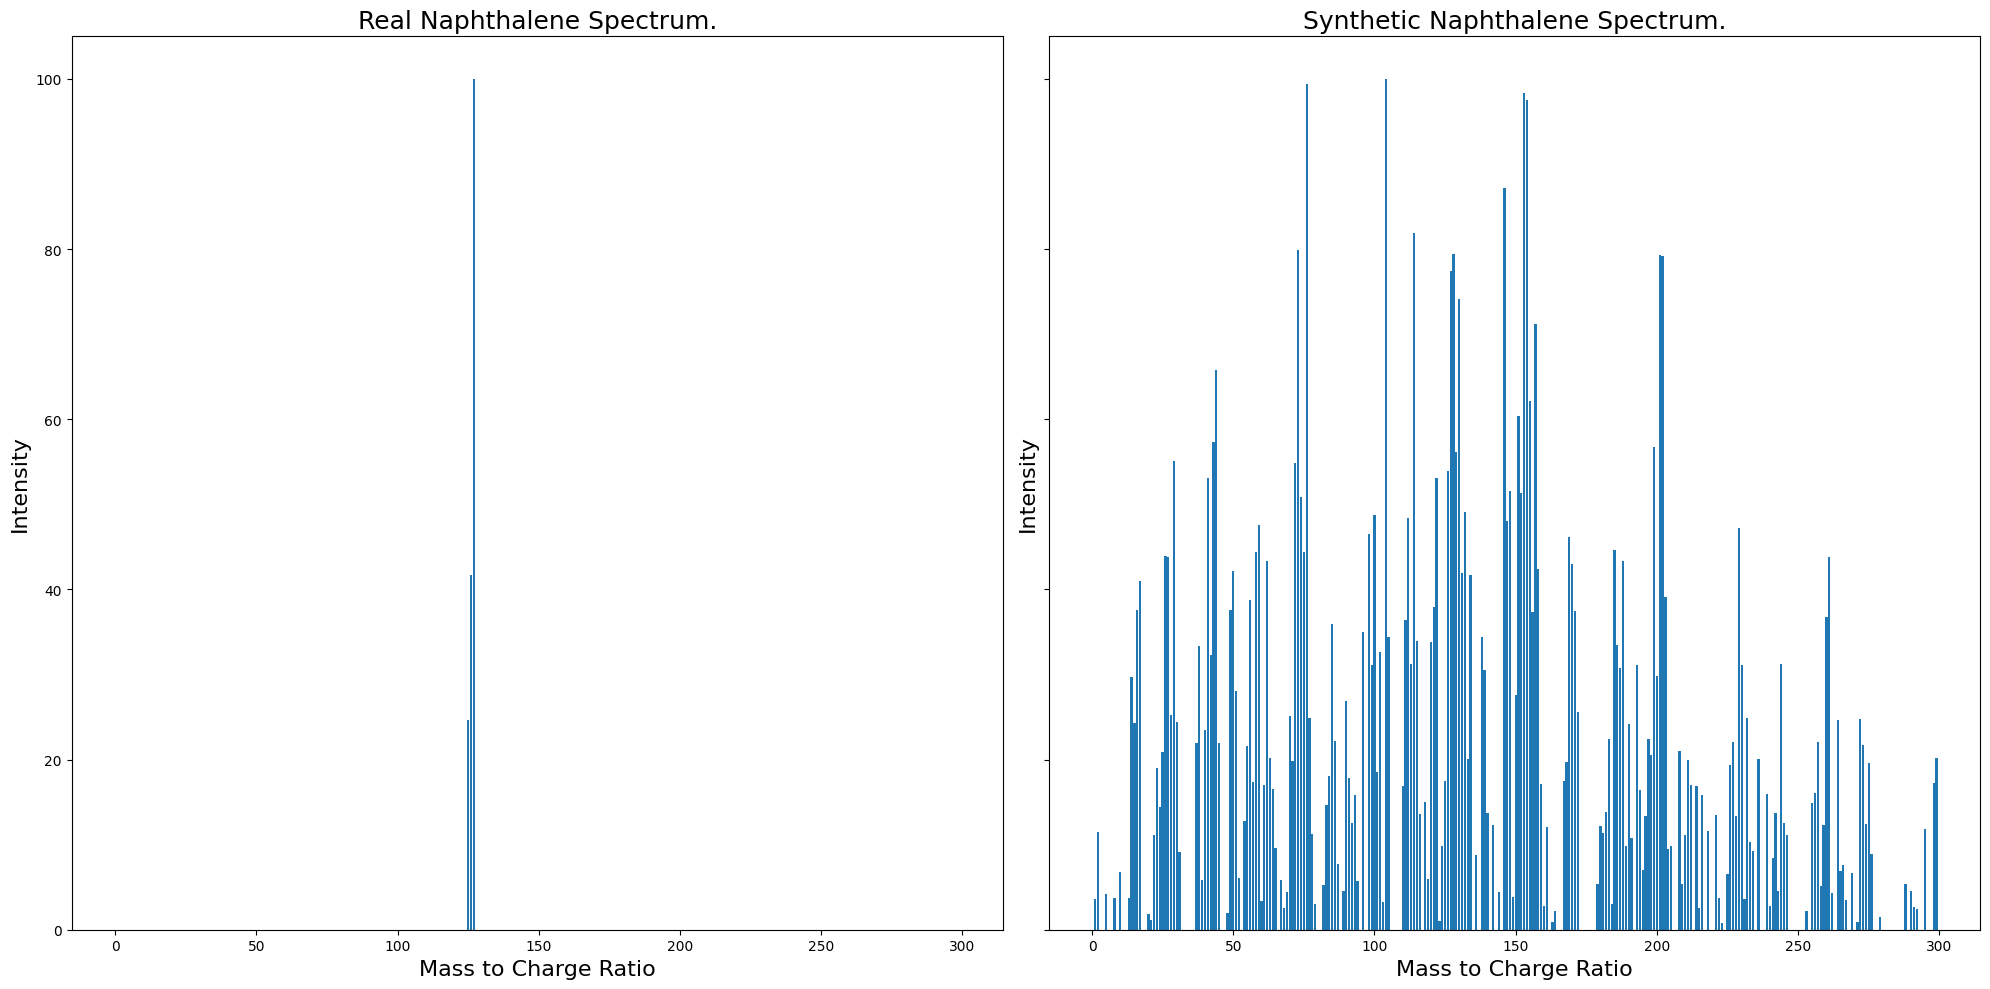

Weighted cosine similarity is:  0.17


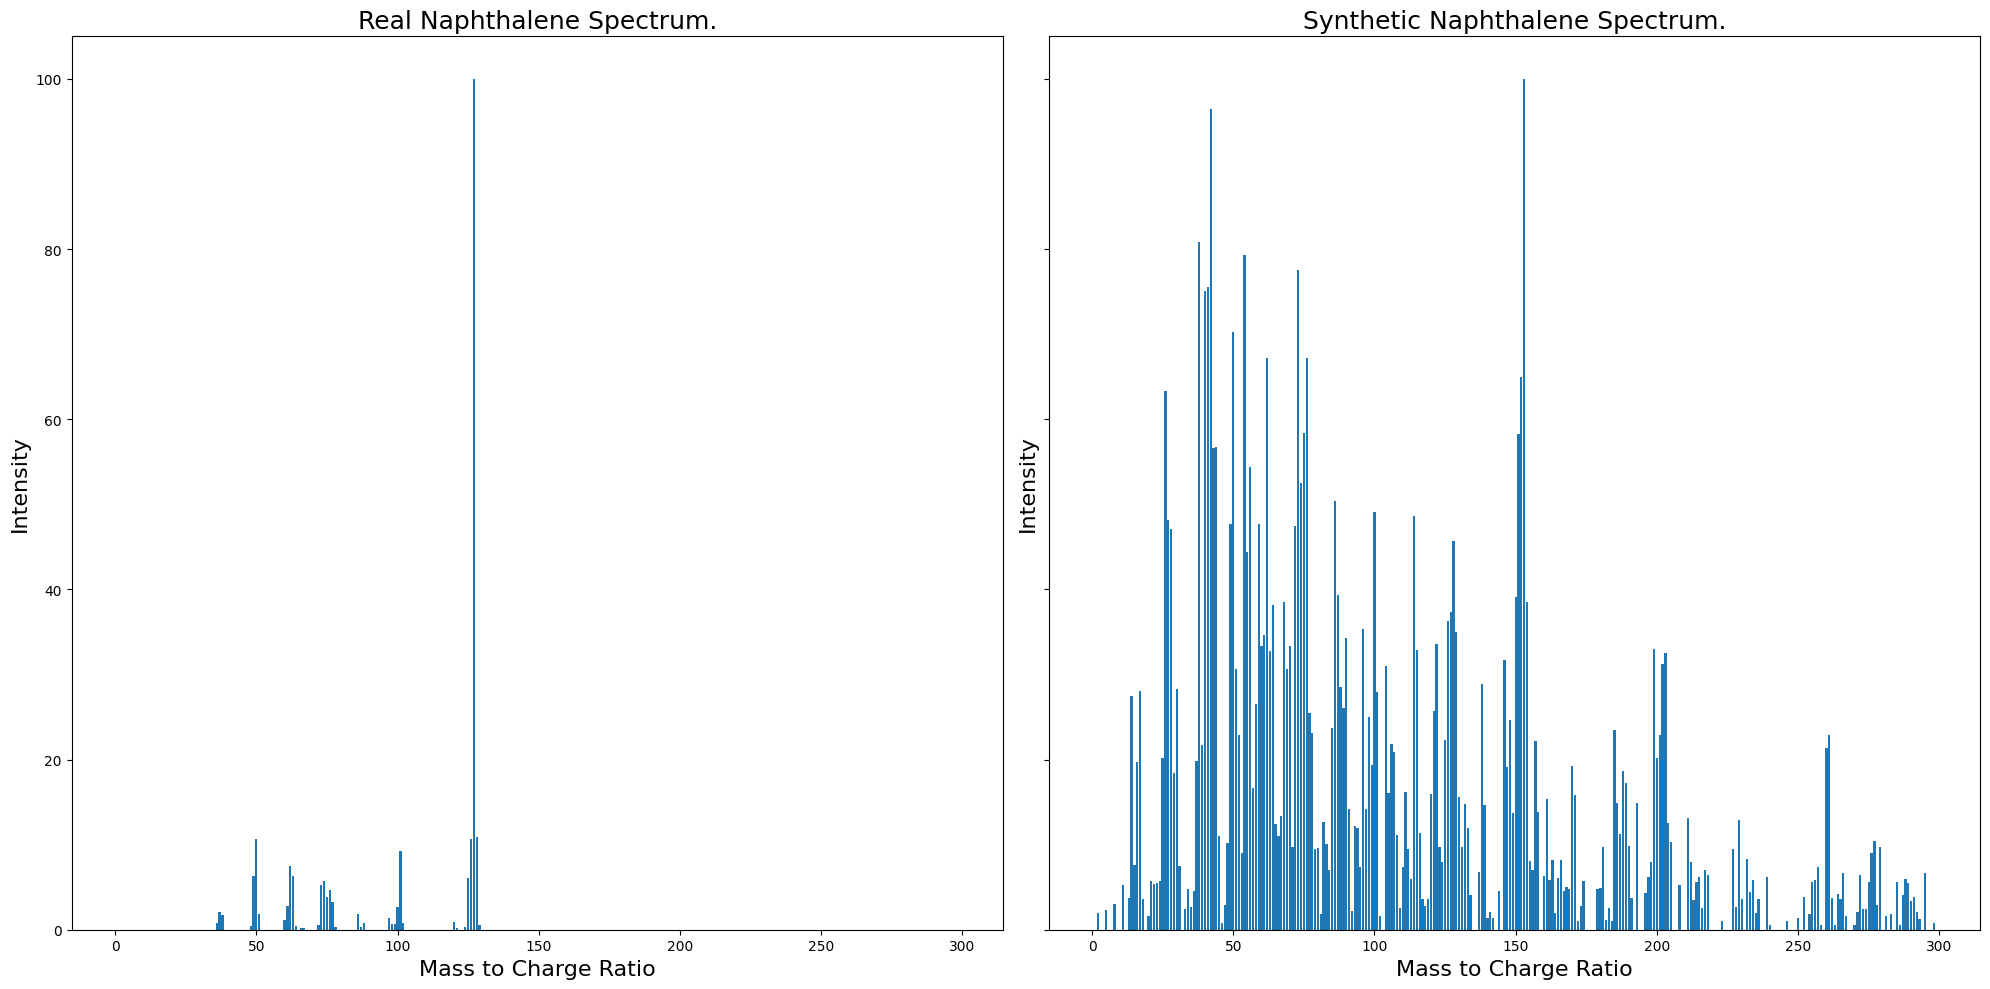

In [15]:
true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
output_spectra = [vec[:915].detach().numpy() for vec in test_output]
plot_results(true_spectra, output_spectra, test_labels, idx=[0,3])

In [ ]:
# test_output_embeddings = [vec[-512:].detach().numpy() for vec in test_output]
# # plot_emb_pca(embeddings, test_output_embeddings, test_labels, train_chems)
# plot_emb_pca(embeddings, test_output_embeddings, test_labels, all_chemical_names)

In [ ]:
# get values for test spectra 
spec_num = 0
true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
fake_spec = true_spectra[spec_num]
# output_spectra = [vec[:915].detach().numpy() for vec in test_output]
# fake_spec = output_spectra[spec_num]
max_val = max(fake_spec)
scaled_spec = [num/max_val * 100 for num in fake_spec]
scaled_spec = [num if num >= 0 else 0 for num in scaled_spec]
threshold = 0
for i, num in enumerate(scaled_spec):
  if num > threshold:
    print(i+1, round(float(num), 4))

# Generate embeddings and then spectra:
---

In [ ]:
# train_data = []
# true_data = []
# for true_val, pred_val in zip(true_values, model_output):
#     train_data_point = true_val
#     for i in enumerate(train_data_point[927:]):
#         train_data_point[i[0]+927] = pred_val[i[0]+927]
#     train_data.append(train_data_point.detach().clone().numpy())
#     true_data.append(true_val.detach().clone().numpy())
    
# # shifting to make all data positive
# min_value = 1
# input_data = torch.tensor(np.vstack((train_data)).T, dtype=torch.float)
# input_data += min_value
# all_true_vals = torch.tensor(np.vstack((true_data)).T, dtype=torch.float)
# all_true_vals += min_value
# # log transforming data to reduce impact of different scales 
# input_normed = torch.log(input_data)
# trues_normed = torch.log(all_true_vals)
# input_data = TensorDataset(input_normed, trues_normed, output_labels)

# batch_size=32
# # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
# input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)